In [1]:
import torch
from torch import Tensor
from torch.nn import *
from torch.optim import Adam
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.nn.functional import interpolate, avg_pool2d
import numpy as np
from random import random
from typing import Any, Dict, Optional
import matplotlib.pyplot as plt

In [2]:
print(16 == 0b10000)
print(16 << 10)

True
16384


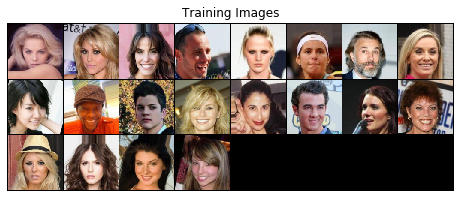

In [3]:
dataroot = "/home/goliot/project/deep_learning_project/img_align_celeba"

batch_size = 20
image_size = 128
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to("cpu")[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
def nf(
    stage: int,
    fmap_base: int = 16 << 10,
    fmap_decay: float = 1.0,
    fmap_min: int = 1,
    fmap_max: int = 512,
) -> int:
    """
    computes the number of fmaps present in each stage
    Args:
        stage: stage level
        fmap_base: base number of fmaps
        fmap_decay: decay rate for the fmaps in the network
        fmap_min: minimum number of fmaps
        fmap_max: maximum number of fmaps
    Returns: number of fmaps that should be present there
    """
    return int(
        np.clip(
            int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_min, fmap_max,
        ).item()
    )

print(nf(6))

256


## Pixel Wise Norm

In [5]:
class PixelwiseNorm(Module):
    """
    ------------------------------------------------------------------------------------
    Pixelwise feature vector normalization.
    reference:
    https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
    ------------------------------------------------------------------------------------
    """

    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    @staticmethod
    def forward(x: Tensor, alpha: float = 1e-8) -> Tensor:
        y = x.pow(2.0).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

## Equalized Conv Transpose 2d

In [6]:
class EqualizedConvTranspose2d(ConvTranspose2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        output_padding=0,
        groups=1,
        bias=True,
        dilation=1,
        padding_mode="zeros",
    ) -> None:
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            output_padding,
            groups,
            bias,
            dilation,
            padding_mode,
        )
        # make sure that the self.weight and self.bias are initialized according to
        # random normal distribution
        torch.nn.init.normal_(self.weight)
        if bias:
            torch.nn.init.zeros_(self.bias)

        # define the scale for the weights:
        fan_in = self.in_channels
        self.scale = np.sqrt(2) / np.sqrt(fan_in)

    def forward(self, x: Tensor, output_size: Any = None) -> Tensor:
        output_padding = self._output_padding(
            input, output_size, self.stride, self.padding, self.kernel_size
        )
        return torch.conv_transpose2d(
            input=x,
            weight=self.weight * self.scale,  # scale the weight on runtime
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            output_padding=output_padding,
            groups=self.groups,
            dilation=self.dilation,
        )

## Equalized Conv 2d

In [7]:

class EqualizedConv2d(Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
        padding_mode="zeros",
    ) -> None:
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        # make sure that the self.weight and self.bias are initialized according to
        # random normal distribution
        torch.nn.init.normal_(self.weight)
        if bias:
            torch.nn.init.zeros_(self.bias)

        # define the scale for the weights:
        fan_in = np.prod(self.kernel_size) * self.in_channels
        self.scale = np.sqrt(2) / np.sqrt(fan_in)

    def forward(self, x: Tensor) -> Tensor:
        return torch.conv2d(
            input=x,
            weight=self.weight * self.scale,  # scale the weight on runtime
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
        )

## Generator Initial Block

In [8]:
class GenInitialBlock(Module):
    """
    Module implementing the initial block of the input
    Args:
        in_channels: number of input channels to the block
        out_channels: number of output channels of the block
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(GenInitialBlock, self).__init__()
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d
        ConvTransposeBlock = EqualizedConvTranspose2d if use_eql else ConvTranspose2d

        self.conv_1 = ConvTransposeBlock(in_channels, out_channels, (4, 4), bias=True)
        self.conv_2 = ConvBlock(
            out_channels, out_channels, (3, 3), padding=1, bias=True
        )
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = torch.unsqueeze(torch.unsqueeze(x, -1), -1)
        y = self.pixNorm(y)  # normalize the latents to hypersphere
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.pixNorm(y)
        return y

## Genrator General Block

In [9]:
class GenGeneralConvBlock(Module):
    """
    Module implementing a general convolutional block
    Args:
        in_channels: number of input channels to the block
        out_channels: number of output channels required
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(GenGeneralConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.conv_1 = ConvBlock(in_channels, out_channels, (3, 3), padding=1, bias=True)
        self.conv_2 = ConvBlock(
            out_channels, out_channels, (3, 3), padding=1, bias=True
        )
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = interpolate(x, scale_factor=2)
        y = self.pixNorm(self.lrelu(self.conv_1(y)))
        y = self.pixNorm(self.lrelu(self.conv_2(y)))

        return y

## Discriminator Final block

In [10]:
class DisFinalBlock(torch.nn.Module):
    """
    Final block for the Discriminator
    Args:
        in_channels: number of input channels
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(DisFinalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.conv_1 = ConvBlock(
            in_channels + 1, in_channels, (3, 3), padding=1, bias=True
        )
        # (16 - 3 + 2 / 1) + 1 = 16
        self.conv_2 = ConvBlock(in_channels, out_channels, (4, 4), bias=True)
        # (16 - 4 / 1) + 1 = 13
        self.conv_3 = ConvBlock(out_channels, 1, (1, 1), bias=True)
        self.batch_discriminator = MinibatchStdDev()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = self.batch_discriminator(x)
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.conv_3(y)
        return y.view(20, -1)

## Discriminator General Conv Block

In [11]:
class DisGeneralConvBlock(Module):
    """
    General block in the discriminator
    Args:
        in_channels: number of input channels
        out_channels: number of output channels
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(DisGeneralConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.conv_1 = ConvBlock(in_channels, in_channels, (3, 3), padding=1, bias=True)
        self.conv_2 = ConvBlock(in_channels, out_channels, (3, 3), padding=1, bias=True)
        self.downSampler = AvgPool2d(2)
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)
        return y

## Minibatch Standart deviation

In [14]:
class MinibatchStdDev(torch.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    Args:
        group_size: Size of each group into which the batch is split
    """

    def __init__(self, group_size: int = 4) -> None:
        """
        Args:
            group_size: Size of each group into which the batch is split
        """
        super(MinibatchStdDev, self).__init__()
        self.group_size = group_size

    def extra_repr(self) -> str:
        return f"group_size={self.group_size}"

    def forward(self, x: Tensor, alpha: float = 1e-8) -> Tensor:
        """
        forward pass of the layer
        Args:
            x: input activation volume
            alpha: small number for numerical stability
        Returns: y => x appended with standard deviation constant map
        """
        batch_size, channels, height, width = x.shape
        if batch_size > self.group_size:
            assert batch_size % self.group_size == 0, (
                f"batch_size {batch_size} should be "
                f"perfectly divisible by group_size {self.group_size}"
            )
            group_size = self.group_size
        else:
            group_size = batch_size

        # reshape x into a more amenable sized tensor
        y = torch.reshape(x, [group_size, -1, channels, height, width])

        # indicated shapes are after performing the operation
        # [G x M x C x H x W] Subtract mean over groups
        y = y - y.mean(dim=0, keepdim=True)

        # [M x C x H x W] Calc standard deviation over the groups
        y = torch.sqrt(y.square().mean(dim=0, keepdim=False) + alpha)

        # [M x 1 x 1 x 1]  Take average over feature_maps and pixels.
        y = y.mean(dim=[1, 2, 3], keepdim=True)

        # [B x 1 x H x W]  Replicate over group and pixels
        y = y.repeat(group_size, 1, height, width)

        # [B x (C + 1) x H x W]  Append as new feature_map.
        y = torch.cat([x, y], 1)

        # return the computed values:
        return y


class Discriminator(Module):
    """
    Discriminator of the GAN
    Args:
        depth: depth of the discriminator. log_2(resolution)
        num_channels: number of channels of the input images (Default = 3 for RGB)
        latent_size: latent size of the final layer
        use_eql: whether to use the equalized learning rate
        num_classes: number of classes for a conditional discriminator (Default = None)
                     meaning unconditional discriminator
    """

    def __init__(
        self,
        depth: int = 7,
        num_channels: int = 3,
        latent_size: int = 512,
        use_eql: bool = True,
        num_classes: Optional[int] = None,
    ) -> None:
        super().__init__()
        self.depth = depth
        self.num_channels = num_channels
        self.latent_size = latent_size
        self.use_eql = use_eql
        self.num_classes = num_classes
        self.conditional = num_classes is not None

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        if self.conditional:
            self.layers = [ConDisFinalBlock(nf(1), latent_size, num_classes, use_eql)]
        else:
            self.layers = [DisFinalBlock(nf(1), latent_size, use_eql)]

        for stage in range(1, depth - 1):
            self.layers.insert(
                0, DisGeneralConvBlock(nf(stage + 1), nf(stage), use_eql)
            )
        self.layers = ModuleList(self.layers)
        self.from_rgb = ModuleList(
            reversed(
                [
                    ConvBlock(num_channels, nf(stage), kernel_size=(1, 1))
                    for stage in range(1, depth)
                ]
            )
        )

    def forward(
        self, x: Tensor, depth: int, alpha: float, labels: Optional[Tensor] = None
    ) -> Tensor:
        """
        forward pass of the discriminator
        Args:
            x: input to the network
            depth: current depth of operation (Progressive GAN)
            alpha: current value of alpha for fade-in
            labels: labels for conditional discriminator (Default = None)
                    shape => (Batch_size,) shouldn't be a column vector
        Returns: raw discriminator scores
        """
        assert (
            depth <= self.depth
        ), f"Requested output depth {depth} cannot be evaluated"

        if self.conditional:
            assert labels is not None, "Conditional discriminator required labels"

        if depth > 2:
            residual = self.from_rgb[-(depth - 2)](
                avg_pool2d(x, kernel_size=2, stride=2)
            )
            straight = self.layers[-(depth - 1)](self.from_rgb[-(depth - 1)](x))
            y = (alpha * straight) + ((1 - alpha) * residual)
            for layer_block in self.layers[-(depth - 2) : -1]:
                y = layer_block(y)
        else:
            y = self.from_rgb[-1](x)
        if self.conditional:
            y = self.layers[-1](y, labels)
        else:
            y = self.layers[-1](y)
        return y

    def get_save_info(self) -> Dict[str, Any]:
        return {
            "conf": {
                "depth": self.depth,
                "num_channels": self.num_channels,
                "latent_size": self.latent_size,
                "use_eql": self.use_eql,
                "num_classes": self.num_classes,
            },
            "state_dict": self.state_dict(),
        }
disci = Discriminator(depth=7)
disci

In [15]:
(1024 - 3 + 2) / 1 + 1 == 1024
1024/2
512/2
256/2
128/2
64/2
32/2
16/2
8/2

4.0

## class Generator(Module):
    """
    Generator Module (block) of the GAN network
    Args:
        depth: required depth of the Network
        num_channels: number of output channels (default = 3 for RGB)
        latent_size: size of the latent manifold
        use_eql: whether to use equalized learning rate
    """

    def __init__(
        self,
        depth: int = 10,
        num_channels: int = 3,
        latent_size: int = 512,
        use_eql: bool = True,
    ) -> None:
        super().__init__()

        # object state:
        self.depth = depth
        self.latent_size = latent_size
        self.num_channels = num_channels
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.layers = ModuleList(
            [GenInitialBlock(latent_size, nf(1), use_eql=self.use_eql)]
        )
        for stage in range(1, depth - 1):
            self.layers.append(GenGeneralConvBlock(nf(stage), nf(stage + 1), use_eql))

        self.rgb_converters = ModuleList(
            [
                ConvBlock(nf(stage), num_channels, kernel_size=(1, 1))
                for stage in range(1, depth)
            ]
        )

    def forward(self, x: Tensor, depth: int, alpha: float) -> Tensor:
        """
        forward pass of the Generator
        Args:
            x: input latent noise
            depth: depth from where the network's output is required
            alpha: value of alpha for fade-in effect
        Returns: generated images at the give depth's resolution
        """

        assert depth <= self.depth, f"Requested output depth {depth} cannot be produced"

        if depth == 2:
            y = self.rgb_converters[0](self.layers[0](x))
        else:
            y = x
            for layer_block in self.layers[: depth - 2]:
                y = layer_block(y)
            residual = interpolate(self.rgb_converters[depth - 3](y), scale_factor=2)
            straight = self.rgb_converters[depth - 2](self.layers[depth - 2](y))
            y = (alpha * straight) + ((1 - alpha) * residual)
        return y

    def get_save_info(self) -> Dict[str, Any]:
        return {
            "conf": {
                "depth": self.depth,
                "num_channels": self.num_channels,
                "latent_size": self.latent_size,
                "use_eql": self.use_eql,
            },
            "state_dict": self.state_dict(),
        }

model = Generator()
x = torch.randn(512, 512)
x = model(x, 10, 0.1)
x


## Split image

In [16]:
def split_image(x, i, n):
    hw = x.shape[3] + 1
    assert ((hw - 1) - n) % i == 0 and (hw - 1) > n, "Error"
    new_img = []
    x = x.numpy()
    for image in x:
        for line in range(0, hw - n, 1):
            for stride in range(0, hw - n, i):
                new_img.append(image[:, line:line + n, stride:stride + n])
    new_img = np.array(new_img)
    return torch.from_numpy(new_img)

## Generator

In [17]:
class Generator(Module):
    def __init__(self, in_channels, out_channels, use_eql):
        super().__init__()

        ConvBlock = EqualizedConv2d if use_eql else Conv2d
        self.gen_block = ModuleList([GenGeneralConvBlock(nf(8), nf(9), use_eql)])

        self.rgb_converters = ModuleList(
            [
                ConvBlock(nf(9), 3, kernel_size=(1, 1))
            ]
        )

    def forward(self, x):
        for layer in self.gen_block:
            x = layer(x)
        x = self.rgb_converters[0](x)
        return x
    
model = Generator(1, 3, False)
model

Generator(
  (gen_block): ModuleList(
    (0): GenGeneralConvBlock(
      (conv_1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pixNorm): PixelwiseNorm()
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (rgb_converters): ModuleList(
    (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [15]:
def addGenBlock(generator, depth):
    for param in generator.gen_block[0].parameters():
        param.requires_grad = False
    generator.gen_block.insert(0, GenGeneralConvBlock(nf(depth), nf(depth+1), False))
    """i = 0
    for block in model.gen_block:
        print(f"Block {i} : ")
        i += 1
        for param in block.parameters():
            print(f"Requires grad : {param.requires_grad}")
        print("\n")"""
addGenBlock(model, depth)
model

NameError: name 'depth' is not defined

## Discriminator

In [18]:
class Discriminator(Module):
    def __init__(self, latent_size=512, depth=7, use_eql=False):
        super().__init__()
        self.latent_size = latent_size
        self.dis_block = ModuleList([DisFinalBlock(nf(1), latent_size, use_eql)])

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.from_rgb = ModuleList(
            reversed(
                [
                    ConvBlock(3, latent_size, kernel_size=(1, 1))
                ]
            )
        )

    def forward(self, x):
        x = self.from_rgb[0](x)
        for layer in self.dis_block:
            x = layer(x)
        return x

discriminator = Discriminator()
discriminator

Discriminator(
  (dis_block): ModuleList(
    (0): DisFinalBlock(
      (conv_1): Conv2d(513, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
      (conv_3): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (batch_discriminator): MinibatchStdDev(group_size=4)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (from_rgb): ModuleList(
    (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
  )
)

## Add Discriminator Block

In [18]:
def addDisBlock(discriminator, depth):
    for param in discriminator.dis_block[0].parameters():
        param.requires_grad = False
    discriminator.dis_block.insert(0, DisGeneralConvBlock(nf(depth), nf(depth+1), False))
    
addDisBlock(discriminator, 1)
discriminator

Discriminator(
  (dis_block): ModuleList(
    (0): DisGeneralConvBlock(
      (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downSampler): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (1): DisFinalBlock(
      (conv_1): Conv2d(513, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
      (conv_3): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (batch_discriminator): MinibatchStdDev(group_size=4)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (from_rgb): ModuleList(
    (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [175]:
for i in range(10):
    print(f"{i} : {nf(i)}")
    
"""
1->4 == 512 - 512
5 == 256 - 512
"""

0 : 512
1 : 512
2 : 512
3 : 512
4 : 512
5 : 512
6 : 256
7 : 128
8 : 64
9 : 32


'\n1->4 == 512 - 512\n5 == 256 - 512\n'

## Create DCGAN class

In [36]:
class DCGAN():
    def __init__(self, noise_fn, dataloader, device, batch_size=20, lr_g=1e-3, lr_d=2e-4, depth=7):
        self.dataloader = dataloader
        self.device = device
        self.generator = Generator(1, 3, False).to(device)
        self.discriminator = Discriminator().to(device)
        self.noise_fn = noise_fn
        self.batch_size = batch_size

        self.criterion = BCEWithLogitsLoss()
        self.g_optimizer = Adam(self.generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
        self.d_optimizer = Adam(self.discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

        self.target_ones = torch.ones(batch_size, 1)
        self.target_zeros = torch.zeros(batch_size, 1)

    def create_sample(self):
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad:
            samples = self.generator(latent_vec)
        samples = samples.cpu()
        return samples

    def train_step_generator(self):
        self.generator.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        fake_sample = self.generator(latent_vec)
        prediction = self.discriminator(fake_sample)
        loss = self.criterion(prediction, self.target_ones)
        loss.backward()
        self.g_optimizer.step()

        return loss.item()

    def train_step_discriminator(self, real_sample):
        #self.discriminator.zero_grad()
        pred_real = self.discriminator(real_sample)
        loss_real = self.criterion(pred_real, self.target_ones)
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_sample = self.generator(latent_vec)
        fake_pred = self.discriminator(fake_sample)
        loss_fake = self.criterion(fake_pred, self.target_zeros)

        loss = (loss_real + loss_fake) / 2
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()

        return loss_real.item(), loss_fake.item()

    def train_gan(self, stride, kernel_size):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch_i, (image, _) in enumerate(self.dataloader):
            image = split_image(image, stride, kernel_size)
            print(image.shape)
            dataloader_split = torch.utils.data.DataLoader(image, batch_size=batch_size,
                                                           shuffle=True)
            for batch_si, image in enumerate(dataloader_split):
                image = image.to(self.device)
                ldr, ldf = self.train_step_discriminator(image)
                loss_d_fake_running += ldf
                loss_d_real_running += ldr
                if batch_si%5==0:
                    loss_g_running += self.train_step_generator()
                if batch_si % 20 == 19:
                    print(f"Loss generator : {loss_g_running / (batch_si + 1)}")
                    print(f"Loss discriminator fake : {loss_d_fake_running / (batch_si + 1)}")
                    print(f"Loss discriminator real : {loss_d_real_running / (batch_si + 1)}")

## Main Function

In [37]:
import time

def main(dataloader, ngpu=0):
    size = []
    batch_size = 20
    epochs = 1
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    latent_size = 4
    noise_fn = lambda x: torch.randn(x, 64, 2, 2)
    gan = DCGAN(noise_fn=noise_fn, dataloader=dataloader, device=device, batch_size=batch_size)
    for i in range(epochs):
        start = time.time()
        gan.train_gan(2, 4)
        print(f"Epoch {i + 1}; Elapsed time = {int(time.time() - start)}s")

In [38]:
main(dataloader)

torch.Size([157500, 3, 4, 4])
Loss generator : 0.3981728732585907
Loss discriminator fake : 0.5308747291564941
Loss discriminator real : 0.41768066547811034
Loss generator : 0.48235908448696135
Loss discriminator fake : 0.3973730096593499
Loss discriminator real : 0.37561194244772195
Loss generator : 0.4920707106590271
Loss discriminator fake : 0.37062587632487215
Loss discriminator real : 0.35344521701335907
Loss generator : 0.5145647242665291
Loss discriminator fake : 0.37370380869251674
Loss discriminator real : 0.3547405070625246
Loss generator : 0.5158397710323334
Loss discriminator fake : 0.3450508327642456
Loss discriminator real : 0.3399912527948618
Loss generator : 0.50746325502793
Loss discriminator fake : 0.33654078465964027
Loss discriminator real : 0.341002477457126
Loss generator : 0.5383109113999776
Loss discriminator fake : 0.3298827359486105
Loss discriminator real : 0.3415857175098998
Loss generator : 0.5160669010132551
Loss discriminator fake : 0.32626288226165345
Lo

KeyboardInterrupt: 

In [ ]:
x = torch.randn(20, 64, 128, 128)
x = split_image(x, 1, 16)
x